In [ ]:
#GAN Notebook (Generative Adversarial Networks)


In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import time as time
import numpy as np
from IPython import display


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.9MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



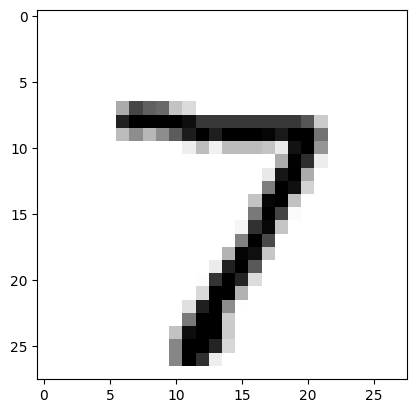

Image size torch.Size([1, 28, 28])
Label 7


In [ ]:
dataset = MNIST(root='./', train=False, download=True, transform=ToTensor())
image, label = dataset.__getitem__(0)
plt.imshow(image.squeeze(0), cmap='binary')
plt.show()
print('Image size', image.shape)
print("Label", label)

In [ ]:
BATCH_SIZE=128
device='cuda' if torch.cuda.is_available() else 'cpu'
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())



In [ ]:
#Generator class
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    self.input_size=input_size

    self.fc_net = nn.Sequential(
        nn.Linear(input_size, 256*7*7, bias=False),
        nn.BatchNorm1d(256*7*7),
        nn.LeakyReLU()
        )

    #kernel_size=5
    self.conv_model = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 5, bias=False, padding=2),
        nn.BatchNorm2d((128)),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(128, 64, 5, bias=False, stride=2, padding=2, output_padding=1),
        nn.BatchNorm2d((64)),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 1, 5, bias=False, stride=2, padding=2, output_padding=1),
        nn.Sigmoid()
        )

  def forward(self, x):
    y = self.fc_net(x)
    y = y.reshape((-1,256,7,7)) #Reshapes x from Nx(256*7*7) to Nx256x7x7
    y = self.conv_model(y)
    return y

In [ ]:
  def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
      nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
      nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.2)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
#Provide a noise vector of size [1,100]
generator = Generator(100)
generator.apply(weights_init)

Generator(
  (fc_net): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

torch.Size([10, 100])
torch.Size([10, 1, 28, 28])


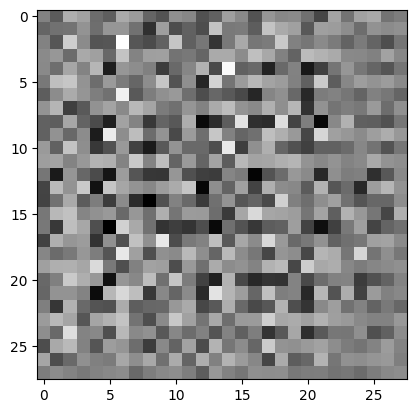

In [ ]:
noise = torch.normal(0, 1, [10, 100])
print(noise.shape)
generated_image = generator(noise).detach()
print(generated_image.shape)

plt.imshow(generated_image.squeeze()[0], cmap='gray')

In [ ]:
#Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    #kernel_size=5 input_channels = 1
    self.model = nn.Sequential(
        nn.Conv2d(1, 64, 5, stride=2, padding=2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(64, 128, 5, stride=2, padding=2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(128, 128, 5, stride=2, padding=2),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Flatten(),
        nn.Linear(2048,1)
        )

  def forward(self, x):
    y = self.model(x)
    return y

In [ ]:
discriminator = Discriminator()
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [ ]:
decision = discriminator(generated_image)
print(decision)

tensor([[-0.1421],
        [-0.1294],
        [-0.0488],
        [-0.1553],
        [-0.0771],
        [-0.0975],
        [-0.1525],
        [-0.0357],
        [-0.0977],
        [-0.0247]], grad_fn=<AddmmBackward0>)


In [ ]:
#Define the GAN Discriminator loss
cross_entropy = nn.BCEWithLogitsLoss()
def discriminator_loss(real_output, fake_output, device):
  #cross_entropy(input_tensor, target_tensor)
  real_loss = cross_entropy(real_output, torch.ones_like(real_output, device=device))
  fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output, device=device))
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
#Generator loss
def generator_loss(fake_output, device):
  gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))
  return gen_loss

In [ ]:
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4)



In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = torch.randn([num_examples_to_generate, noise_dim], device=device)


In [ ]:
def train_step(images, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt):
  #detach the generated images when iptimizing the Discriminator, do not want gradients to flow through Generator in this step.
  noise = torch.randn([BATCH_SIZE, noise_dim], device=device)

  #Generate images
  generated_images = generator(noise)

  #Classify true and fake images (NB: remember to stop gradient using detach when predicting fake images)
  real_output = discriminator(images)
  fake_output = discriminator(generated_images.detach())

  #Compute discriminator loss and update the discriminator
  disc_loss = discriminator_loss(real_output, fake_output, device)
  dis_opt.zero_grad()
  disc_loss.backward()
  dis_opt.step()

  #Compute predictions where gradients can flow to the generator of fake samples
  fake_output = discriminator(generated_images)

  #Compute the gradient loss and update the generator
  gen_loss = generator_loss(fake_output, device)
  gen_opt.zero_grad()
  gen_loss.backward()
  gen_opt.step()

  return gen_loss, disc_loss


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  model.eval()
  with torch.no_grad():
    predictions = model(test_input).detach().cpu()*250
  grid = make_grid(predictions, 4).numpy().squeeze().transpose(1,2,0)

  plt.imshow(grid.astype(np.uint8), cmap='binary')
  plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

  model.train()

In [ ]:
def train(dataloader, epochs, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt):
  gloss=[]
  dloss=[]
  for epoch in range(epochs):
    start = time.time()

    gen_losses=[]
    disc_losses=[]
    for image_batch, _ in dataloader:
      image_batch = image_batch.to(device)
      gen_loss, disc_loss = train_step(image_batch, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt)
      gen_losses.append(gen_loss.detach().cpu())
      disc_losses.append(disc_loss.detach().cpu())

    gloss.append(np.mean(gen_losses))
    dloss.append(np.mean(disc_losses))
    #Produce images

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  #Generate after final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  return gloss, dloss

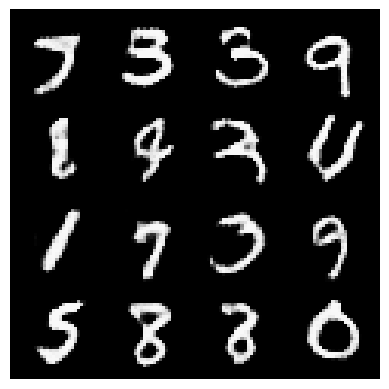

In [ ]:
generator.to(device)
discriminator.to(device)
gloss, dloss = train(dataloader, EPOCHS, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt)


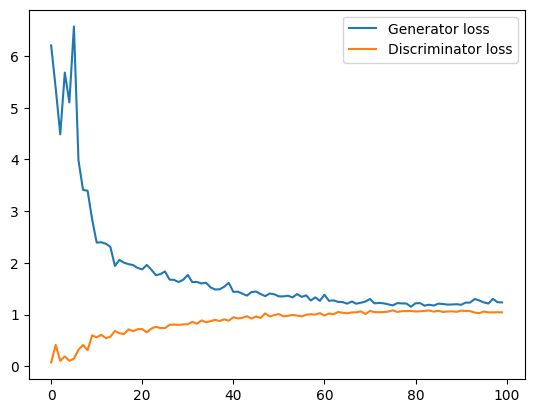

In [ ]:
plt.plot(gloss, label="Generator loss")
plt.plot(dloss, label="Discriminator loss")
plt.legend()
plt.show()